In [2]:
# Step 1: Import libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.18.0


In [3]:
# Step 2: Load the IMDB dataset
(train_data, test_data), info = tfds.load(
    'imdb_reviews',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

print("Dataset loaded successfully")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.ELI8D8_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.ELI8D8_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.ELI8D8_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Dataset loaded successfully


In [4]:
# Step 3: Preview a few examples
for example, label in train_data.take(3):
    print(f"Review: {example.numpy()[:300]}")
    print(f"Label: {label.numpy()}\n")


Review: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda pi"
Label: 0

Review: b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Cons'
Label: 0

Review: b'Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marshal (yes a marshal!) and to e'
Label: 0



In [5]:
# Step 4: Prepare the text encoder
encoder = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (text.numpy() for text, _ in train_data),
    target_vocab_size=2**15
)

print("Vocabulary size:", encoder.vocab_size)


Vocabulary size: 32650


In [6]:
# Step 5: Encode and pad the sequences
BUFFER_SIZE = 10000
BATCH_SIZE = 64

def encode(text, label):
    encoded_text = encoder.encode(text.numpy())
    return encoded_text, label

def tf_encode(text, label):
    encoded_text, label = tf.py_function(encode, inp=[text, label], Tout=(tf.int64, tf.int64))
    encoded_text.set_shape([None])
    label.set_shape([])
    return encoded_text, label

train_dataset = train_data.map(tf_encode)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, padded_shapes=([None], []))

test_dataset = test_data.map(tf_encode)
test_dataset = test_dataset.padded_batch(BATCH_SIZE, padded_shapes=([None], []))


In [7]:
# Step 6: Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

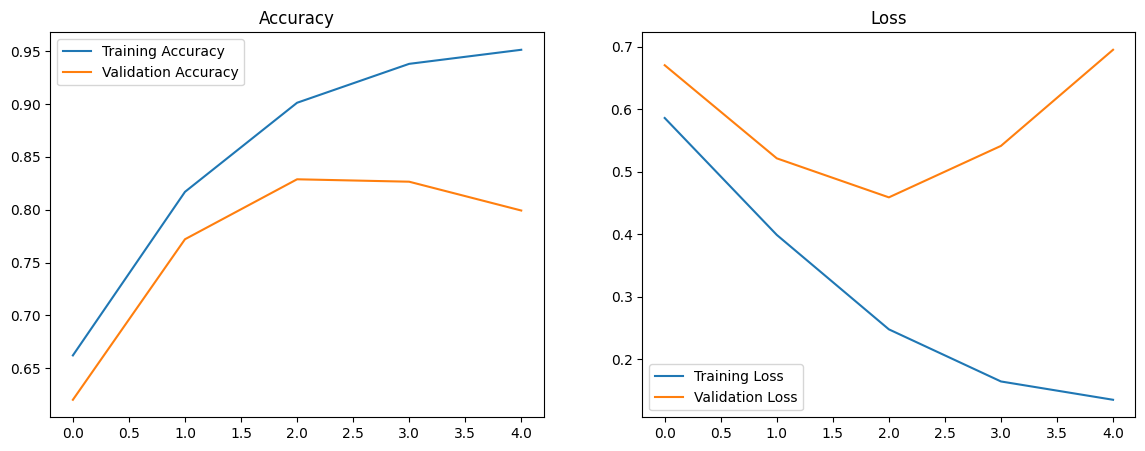

In [9]:
# Step 8: Plot accuracy and loss
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_metrics(history)


In [10]:
# Step 9: Try custom prediction
def predict_sentiment(text):
    encoded = encoder.encode(text)
    padded = tf.keras.preprocessing.sequence.pad_sequences([encoded], maxlen=250)
    prediction = tf.sigmoid(model.predict(padded)[0][0]).numpy()
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    print(f"Sentiment: {sentiment} ({prediction:.2f})")

predict_sentiment("The movie was amazing and I loved the story!")
predict_sentiment("It was boring and a waste of time.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
Sentiment: Positive (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Sentiment: Positive (1.00)
